In [46]:
# In order to push without output, use the following command:
#git push --quiet -u --no-progress 

datadir = "../data/"
datafilename = "ITAprojectevaluation_C_ML_corrected.xlsx"
datafilepath = datadir + datafilename

In [47]:
import pandas as pd

df1 = pd.read_excel(datafilepath, sheet_name='Link_info')
df1_unique = df1.drop_duplicates(subset=['Link ID']).dropna(subset=['Link ID', 'A X_COORD', 'A Y_COORD', 'B X_COORD', 'B Y_COORD'])

a_nodes = df1_unique[['ANODE', 'A X_COORD', 'A Y_COORD']].rename(columns={"ANODE": "node_id", "A X_COORD": "x_coord", "A Y_COORD": "y_coord"})
b_nodes = df1_unique[['BNODE', 'B X_COORD', 'B Y_COORD']].rename(columns={"BNODE": "node_id", "B X_COORD": "x_coord", "B Y_COORD": "y_coord"})
nodes = pd.concat([a_nodes, b_nodes]).drop_duplicates().apply(pd.to_numeric)
# There are duplicate node_ids with different coordinates!
# For an example:
# print(nodes.loc[nodes['node_id'] == 11175])
# TODO: Figure out why
nodes = nodes.drop_duplicates(subset=['node_id'])

a_edges = df1_unique[['Link ID', 'ANODE', 'BNODE', 'CapAB']].rename(columns={'Link ID': 'edge_id', "ANODE": "src", "BNODE": "dest", "CapAB": "capacity"})
b_edges = df1_unique[['Link ID', 'BNODE', 'ANODE', 'CapBA']].rename(columns={'Link ID': 'edge_id', "BNODE": "src", "ANODE": "dest", "CapBA": "capacity"})
edges = pd.concat([a_edges, b_edges]).drop_duplicates().apply(pd.to_numeric)
# There are duplicate edge_ids with different src,dest and different capacities!
# For an example:
# print(edges.loc[edges['edge_id'] == 9197])
# TODO: Figure out why
edges = edges.drop_duplicates(subset=['edge_id'])

# For now, we're only interested in two columns
# AADT(2010)-B is the "before" treatment. We treat this as an additional edge feature
# AADT(2010)-A is the "after" treatment. We treat this as the response variable
df2 = pd.read_excel(datafilepath, sheet_name='AADT_Benefits_C').drop_duplicates(subset=['Link ID']).dropna(subset=['Link ID','AADT(2010)-A','AADT(2010)-B'])
df2 = df2[['Link ID', '# of lanes', 'AADT(2010)-A']].rename(columns={'Link ID': 'edge_id'}).drop_duplicates().apply(pd.to_numeric)
edges = edges.merge(right=df2, on=['edge_id'], how='left')

print(df1_unique.head())
print("\n nodes.head()")
print(nodes.head())
print("\n edges.head()")
print(edges.head())

   Link ID   ANODE   BNODE A X_COORD  A Y_COORD  B X_COORD  B Y_COORD   CapAB  \
1   6087.0  8921.0  8981.0  407624.2  4649654.5   408005.8  4649863.0  4000.0   
2   6457.0  9137.0  8980.0  409288.6  4649934.5   408004.0  4649903.5  4000.0   
3   6262.0  9027.0  9141.0    408444  4649861.0   409327.9  4649862.0  4000.0   
4   6465.0  9141.0  9267.0  409327.9  4649862.0   410370.2  4649433.0  4000.0   
5   6660.0  9264.0  9137.0  410362.6  4649530.5   409288.6  4649934.5  4000.0   

   CapBA  
1    0.0  
2    0.0  
3    0.0  
4    0.0  
5    0.0  

 nodes.head()
   node_id   x_coord    y_coord
1   8921.0  407624.2  4649654.5
2   9137.0  409288.6  4649934.5
3   9027.0  408444.0  4649861.0
4   9141.0  409327.9  4649862.0
5   9264.0  410362.6  4649530.5

 edges.head()
   edge_id     src    dest  capacity  # of lanes   AADT(2010)-A
0   6087.0  8921.0  8981.0    4000.0         3.5   65590.052876
1   6457.0  9137.0  8980.0    4000.0         3.5   90151.850498
2   6262.0  9027.0  9141.0    400

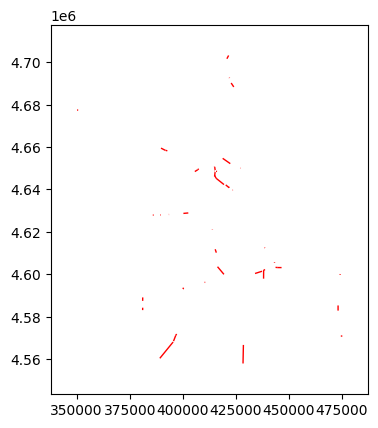

In [48]:
# Visualize the dataset
from matplotlib import collections  as mc
import pylab as pl

viz_subset = df1_unique.sample(n=50)
srcs  = zip(viz_subset['A X_COORD'], viz_subset['A Y_COORD'])
dests  = zip(viz_subset['B X_COORD'], viz_subset['B Y_COORD'])
lines = [list(a) for a in zip(srcs, dests)]

# Taken from https://stackoverflow.com/questions/21352580/plotting-numerous-disconnected-line-segments-with-different-colors
linecollection = mc.LineCollection(lines, colors=(1,0,0,1), linewidths=1)
fig, ax = pl.subplots()
ax.add_collection(linecollection)
ax.autoscale()
ax.set_aspect('equal', 'box')
ax.margins(0.1)

In [49]:
import torch
from itertools import chain, combinations

# This is the target of the prediction ("ground truth")
y_tensor = torch.tensor(edges['AADT(2010)-A'].values)
y_tensor = y_tensor.to(torch.float32)

"""# Build a map from node_id to index (basically enumerate the n unique node_ids from 0 to n-1)
unique_node_ids = nodes['node_id'].unique()
node_id_to_idx  = dict(zip(unique_node_ids, range(len(unique_node_ids))))

nodes_tensor = torch.tensor(nodes[['x_coord','y_coord']].values)
# print(nodes_tensor)

edges_tensor = torch.tensor(edges[['src', 'dest']].apply(lambda x: [node_id_to_idx[elem] for elem in x]).values).T
edge_features_tensor = torch.tensor(edges[['capacity','AADT(2010)-B']].values).squeeze(1)
# print(edges_tensor)
# print(edge_features_tensor)"""

# The above code should be used eventually, but for now, I'm "inverting" the problem formulation to make it easier to plug into
# existing GNNs. Namely, I will be using the Line Graph (https://en.wikipedia.org/wiki/Line_graph) instead of the original graph

# Build a map from edge_id to index (basically enumerate the n unique node_ids from 0 to n-1)
unique_edge_ids = edges['edge_id'].unique()
edge_id_to_idx  = dict(zip(unique_edge_ids, range(len(unique_edge_ids))))

# Build a map from node_id to a list of edge_ids that are incident to that node
# For each edge, create tuples (src, edge_id), (dest, edge_id)
entries = zip(pd.concat([edges['src'],edges['dest']]), chain(range(len(unique_edge_ids)), range(len(unique_edge_ids))))
node_to_edges = {}
for node_id, edge_id in entries:
    if node_id not in node_to_edges:
        node_to_edges[node_id] = [edge_id]
    else:
        node_to_edges[node_id].append(edge_id)

# Actually, we want to cram as much information as we can into each edge because these will be the features
# Namely, we will put the x,y coordinates of src/dest into each edge as well
edges_augmented = edges.merge(nodes, how='inner', left_on='src', right_on='node_id').rename(columns={"x_coord": "src_x_coord", "y_coord": "src_y_coord"})
edges_augmented = edges_augmented.drop(columns='node_id')
edges_augmented = edges_augmented.merge(nodes, how='inner', left_on='dest', right_on='node_id').rename(columns={"x_coord": "dest_x_coord", "y_coord": "dest_y_coord"})
edges_augmented = edges_augmented.drop(columns=['edge_id','AADT(2010)-A','src','dest','node_id'])
print("\nedges_augmented")
print(edges_augmented)

# Finalizing our input tensors
nodes_tensor = torch.tensor(edges_augmented.values)
nodes_tensor = nodes_tensor.to(torch.float32)
print("\nnodes_tensor")
print(nodes_tensor)

# Edges in the original graph become nodes
# First, every edge should be connected to itself
edges_tensor = torch.cat((torch.unsqueeze(torch.arange(0, len(unique_edge_ids)),0),torch.unsqueeze(torch.arange(0, len(unique_edge_ids)),0)), 0)

# Then for every node in the original graph, we generate (degree choose 2) edges in the line graph
for node_id, edge_list in node_to_edges.items():
    # We actually don't even need the node id here! just do all choose 2
    if len(edge_list) == 0:
        continue
    for comb in combinations(edge_list, 2):
        new_thing = torch.tensor([comb[0],comb[1]]).unsqueeze(1)
        edges_tensor = torch.cat([edges_tensor, torch.tensor([comb[0],comb[1]]).unsqueeze(1)], 1)

print("\nedges_tensor")
print(edges_tensor)


edges_augmented
     capacity  # of lanes  src_x_coord  src_y_coord  dest_x_coord  \
0      4000.0         3.5     407624.2    4649654.5      408005.8   
1      4000.0         3.5     409288.6    4649934.5      408004.0   
2      4000.0         3.5     408444.0    4649861.0      409327.9   
3      4000.0         3.5     409327.9    4649862.0      410370.2   
4      4000.0         3.5     410362.6    4649530.5      409288.6   
..        ...         ...          ...          ...           ...   
563    1660.0         3.5     418256.4    4648479.6      418818.6   
564    2520.0         3.5     418818.6    4648483.5      419087.3   
565    2160.0         3.5     419087.3    4648470.0      419615.7   
566    1440.0         3.5     419615.7    4648447.5      420538.3   
567    1620.0         3.5     420538.3    4648300.5      422144.6   

     dest_y_coord  
0       4649863.0  
1       4649903.5  
2       4649862.0  
3       4649433.0  
4       4649934.5  
..            ...  
563     464848

In [50]:
# Define a simple GCN
# Taken from https://www.datacamp.com/tutorial/comprehensive-introduction-graph-neural-networks-gnns-tutorial
# Eventually, this should be moved to the src/ directory

from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(42)
        # The first number (6) is num_features. todo: this shouldn't be hardcoded
        self.conv1 = GCNConv(in_channels=6, out_channels=hidden_channels)
        self.conv2 = GCNConv(in_channels=hidden_channels, out_channels=1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x


In [51]:
import random

# Create train/val/test split
num_datapoints = len(edges.index)
shuffled_indices = list(range(num_datapoints))
random.shuffle(shuffled_indices)
train_frac = .7
val_frac   = .15
test_frac  = .15
train_indices = shuffled_indices[:int(num_datapoints*train_frac)]
val_indices   = shuffled_indices[int(num_datapoints*train_frac):int(num_datapoints*(train_frac+val_frac))]
test_indices  = shuffled_indices[int(num_datapoints*(train_frac+val_frac)):]

train_mask = torch.zeros(num_datapoints)
val_mask   = torch.zeros(num_datapoints)
test_mask  = torch.zeros(num_datapoints)

train_mask[train_indices] = 1
val_mask[val_indices]     = 1
test_mask[test_indices]   = 1

train_mask = train_mask.to(torch.bool)
val_mask   = val_mask.to(torch.bool)
test_mask  = test_mask.to(torch.bool)

In [52]:
# print(nodes_tensor.shape)
# print(nodes_tensor.dtype)
# print(edges_tensor.shape)
# print(edges_tensor.dtype)
# print(y_tensor.shape)
# print(y_tensor.dtype)
# print(train_mask.shape)
# print(train_mask.dtype)
# print(train_mask)

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.MSELoss()

def train():
      model.train()
      optimizer.zero_grad()
      out = model(nodes_tensor, edges_tensor)
      loss = criterion(out[train_mask].squeeze(1), y_tensor[train_mask])
      loss.backward()
      optimizer.step()
      return loss


def test(mask):
      model.eval()
      out = model(nodes_tensor, edges_tensor)
      return criterion(out[mask].squeeze(1), y_tensor[mask])

# Todo: There should probably be some logic here to keep going until we see N iterations without
#       an improvement in validation loss
val_losses = []
lowest_val_loss       = float("inf")
lowest_val_loss_epoch = -1

for epoch in range(1, 501):
    loss = train()
    val_loss = test(val_mask)
    val_losses.append(val_loss)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val_loss: {val_loss:.4f}')
    if val_loss < lowest_val_loss:
        lowest_val_loss       = val_loss
        lowest_val_loss_epoch = epoch
        torch.save(model.state_dict(), "checkpoint.pth")
        print("New lowest validation loss. Saved model")

with torch.no_grad():
    model.load_state_dict(torch.load("checkpoint.pth"))
    model.eval()
    test_out = model(nodes_tensor, edges_tensor)
    test_loss = criterion(test_out[test_mask].squeeze(1), y_tensor[test_mask])
    abs_y_tensor = criterion(torch.zeros(torch.Tensor.size(y_tensor[test_mask])), y_tensor[test_mask])
    #test_loss_relative = test_loss/criterion(torch.zeros(torch.Tensor.size(y_tensor[test_mask])), y_tensor[test_mask]) #relative test error
    test_loss_relative = test_loss/abs_y_tensor

print("\nGround truth (AADT(2010)-A values that were assigned to the test part):")
print(y_tensor[test_mask])
print("\nModel predictions (estimated AADT(2010)-A values of the test part, i.e., estimated by the GNN):")
print(test_out[test_mask].squeeze(1))

print("\nRelative Test loss (squared error between the above two vectors / abs(y_tensor)")
print("\n = ", format(test_loss.item(), '.2e'), " / ", format(abs_y_tensor.item(),'.2e'), " = ", format(test_loss_relative.item(),'.2e'), "\n")
 



Epoch: 001, Loss: 918859415552.0000, Val_loss: 598977085440.0000
New lowest validation loss. Saved model
Epoch: 002, Loss: 711258734592.0000, Val_loss: 413089824768.0000
New lowest validation loss. Saved model
Epoch: 003, Loss: 469169438720.0000, Val_loss: 268802506752.0000
New lowest validation loss. Saved model
Epoch: 004, Loss: 321676541952.0000, Val_loss: 161457963008.0000
New lowest validation loss. Saved model
Epoch: 005, Loss: 228040736768.0000, Val_loss: 85879013376.0000
New lowest validation loss. Saved model
Epoch: 006, Loss: 138395041792.0000, Val_loss: 38555160576.0000
New lowest validation loss. Saved model
Epoch: 007, Loss: 69672304640.0000, Val_loss: 17569536000.0000
New lowest validation loss. Saved model
Epoch: 008, Loss: 49266835456.0000, Val_loss: 9290528768.0000
New lowest validation loss. Saved model
Epoch: 009, Loss: 42880274432.0000, Val_loss: 5621113856.0000
New lowest validation loss. Saved model
Epoch: 010, Loss: 39819513856.0000, Val_loss: 5029455360.0000
New

In [53]:
# Below are some links that I found helpful

# https://arxiv.org/pdf/1609.02907.pdf (note: this is the net that GCNConv implements)
#         (SEMI-SUPERVISED CLASSIFICATION WITH GRAPH CONVOLUTIONAL NETWORKS)
# But, the issue with the above is that we need a GNN to predict links/edges. GCNConv only does nodes
# That's why I had to use the link graph trick

# https://rish-16.github.io/posts/gnn-math/ (Math Behind Graph Neural Networks)  

# https://blog.dataiku.com/graph-neural-networks-link-prediction-part-two

# https://arxiv.org/pdf/1901.00596.pdf (A Comprehensive Survey on Graph Neural Networks)
# https://arxiv.org/pdf/1609.02907.pdf (SEMI-SUPERVISED CLASSIFICATION WITH GRAPH CONVOLUTIONAL NETWORKS)
# https://arxiv.org/pdf/2302.05631.pdf (A Survey on Spectral Graph Neural Networks)

In [54]:
# Below is some code that I copied over (with very minor modifications) to view the "quickstart.xlsx" file

In [55]:
# datadir = "../data/"
# datafilename = "quickstart.xlsx"
# datafilepath = datadir + datafilename

In [56]:
# import pandas as pd

# df1 = pd.read_excel(datafilepath, sheet_name='Network connectivity')
# df1_unique = df1.drop_duplicates(subset=['Link ID']).dropna(subset=['Link ID', 'A X_COORD', 'A Y_COORD', 'B X_COORD', 'B Y_COORD'])

# a_nodes = df1_unique[['ANODE', 'A X_COORD', 'A Y_COORD']].rename(columns={"ANODE": "node_id", "A X_COORD": "x_coord", "A Y_COORD": "y_coord"})
# b_nodes = df1_unique[['BNODE', 'B X_COORD', 'B Y_COORD']].rename(columns={"BNODE": "node_id", "B X_COORD": "x_coord", "B Y_COORD": "y_coord"})
# nodes = pd.concat([a_nodes, b_nodes]).drop_duplicates().apply(pd.to_numeric)
# nodes = nodes.drop_duplicates(subset=['node_id'])

# a_edges = df1_unique[['Link ID', 'ANODE', 'BNODE', 'CapAB']].rename(columns={'Link ID': 'edge_id', "ANODE": "src", "BNODE": "dest", "CapAB": "capacity"})
# b_edges = df1_unique[['Link ID', 'BNODE', 'ANODE', 'CapBA']].rename(columns={'Link ID': 'edge_id', "BNODE": "src", "ANODE": "dest", "CapBA": "capacity"})
# edges = pd.concat([a_edges, b_edges]).drop_duplicates()
# edges[['src','dest','capacity']] = edges[['src','dest','capacity']].apply(pd.to_numeric)
# edges = edges.drop_duplicates(subset=['edge_id'])

# print(df1_unique.head())
# print(nodes.head())
# print(edges.head())

In [57]:
# # Visualize the dataset
# from matplotlib import collections  as mc
# import pylab as pl

# viz_subset = df1_unique
# srcs  = zip(viz_subset['A X_COORD'], viz_subset['A Y_COORD'])
# dests  = zip(viz_subset['B X_COORD'], viz_subset['B Y_COORD'])
# lines = [list(a) for a in zip(srcs, dests)]

# # Taken from https://stackoverflow.com/questions/21352580/plotting-numerous-disconnected-line-segments-with-different-colors
# linecollection = mc.LineCollection(lines, colors=(1,0,0,1), linewidths=1)
# fig, ax = pl.subplots()
# ax.add_collection(linecollection)
# ax.autoscale()
# ax.set_aspect('equal', 'box')
# ax.margins(0.1)